# 🧠🤖 Treinamento de Redes Convolucionais
**Aluno**: Victor Soares Setubal Wingler Lucas

# **Download e Preparo do Dataset**

Primeiramente, iremos fazer o download do dataset:

In [ ]:
import kagglehub

dataset_path = kagglehub.dataset_download("alsaniipe/chest-x-ray-image")

print("Dataset baixado em:", dataset_path)

Using Colab cache for faster access to the 'chest-x-ray-image' dataset.
Dataset baixado em: /kaggle/input/chest-x-ray-image


Agora iremos compreender a organização do dataset que será utilizado.

In [ ]:
# Mostra a estrutura principal do dataset
!ls $dataset_path

Data


In [ ]:
# Entra na pasta principal das imagens
!ls $dataset_path/Data

test  train


In [ ]:
# Mostra as divisões do dataset
!ls $dataset_path/Data/test

COVID19  NORMAL  PNEUMONIA


Com isso, pode-se observar que o conjunto de dados é dividido em três faces: um para treino, um para validação e outro para teste.
E, além disso, temos duas classes de imagens: NORMAL, PNEUMONIA ou COVID.

Agora, visualizaremos alguns dados do dataset:

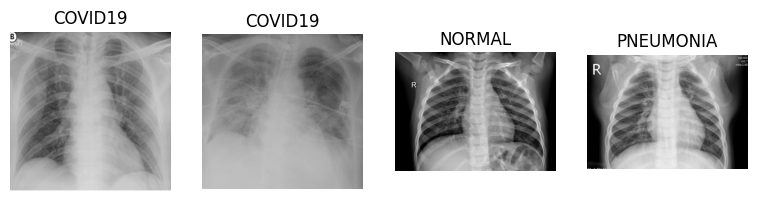

In [ ]:
import random
import matplotlib.pyplot as plt
from PIL import Image
import os

# Caminho do treino
train_path = f"{dataset_path}/Data/train"

# Lista todas as classes
classes = os.listdir(train_path)

plt.figure(figsize=(12, 4))

for i in range(4):
    classe = random.choice(classes)
    classe_path = f"{train_path}/{classe}"
    img_name = random.choice(os.listdir(classe_path))
    img_path = f"{classe_path}/{img_name}"

    img = Image.open(img_path)

    plt.subplot(1, 5, i + 1)
    plt.imshow(img, cmap="gray")
    plt.title(classe)
    plt.axis("off")

plt.show()

Aqui visualiza-se algumas imagens do conjunto de treino e a qual classe a imagem pertence.

Agora vamos de fato montar os nossos datasets de treino, validação e teste utilizando `ImageFolder` .

In [ ]:
from torchvision.datasets import ImageFolder

full_train_dataset = ImageFolder(root=f"{dataset_path}/Data/train")
test_dataset  = ImageFolder(root=f"{dataset_path}/Data/test")

print("Classes:", full_train_dataset.classes)
print("Treino:", len(full_train_dataset))
print("Teste:", len(test_dataset))


Classes: ['COVID19', 'NORMAL', 'PNEUMONIA']
Treino: 5144
Teste: 1288


Dessa forma, é possível ver a quantidade de imagens em cada um dos datasets.

A seguir, uma função para leitura padronizada das imagens:

In [ ]:
from PIL import Image
import torch
from torchvision.transforms import v2

def load_img(path):
  # Le a imagem em diversos formatos e garante que a imagem tenha 3 canais
  img = Image.open(path).convert('RGB')
  # converte para um tensor do pytorch
  img = v2.functional.to_image(img)
  # garante que seja uma imagem de 8 bits reescalando os valores adequadamente
  img = v2.functional.to_dtype(img, dtype=torch.uint8, scale=True)
  return img

Agora visualizaremos se as imagens continuam similares a antes dessas conversões:

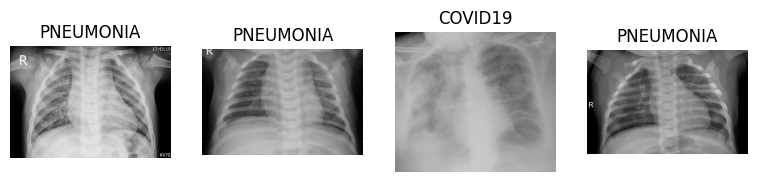

In [ ]:
plt.figure(figsize=(12, 4))

for i in range(4):
    path, label = random.choice(full_train_dataset.samples)
    img = load_img(path)

    plt.subplot(1, 5, i + 1)
    plt.imshow(img.permute(1, 2, 0))
    plt.title(full_train_dataset.classes[label])
    plt.axis("off")

plt.show()

Assim, conseguimos visualizar que as imagens continuam similares a antes da criação dos datasets.

O próximo passo é utilizar data augmentation ao conjunto de treino para possibilitar que o treinamento produza um modelo mais robusto. Para isso, será adicionado as seguintes transformações:
- `RandomHorizontalFlip(p=0.5)`: Espelhamento horizontal da imagem com probabilidade de 50%. O espelhamento não altera o diagnóstico e pode ser utilizado para imagens de raio-x de tórax. Assim, aumenta a diversidade dos dados sem criar informações irreais.
- `RandomRotation(degrees=10)`: Aplica rotações aleatórias entre −10° e +10°. Essas pequenas rotações devem ser aplicadas pois simulam a posição do paciente ou do equipamento que podem variar no momento do exame.

In [ ]:
train_transforms = v2.Compose([
    v2.Resize((224, 224)),
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandomRotation(degrees=10),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

Além dessas operações de data augmentation foram aplicados algumas transformações comuns para o conjunto de treino e que também serão aplicadas aos conjuntos de validação e teste:
- `Resize((224, 224))`: Redimensiona todas as imagens para 224×224 pixels. As CNNs exigem entrada de tamanho fixo e esse dimensionamento é muito comum e muito utilizado em diversas arquiteturas clássicas.
- `ToDtype(torch.float32, scale=True)`: Converte a imagem de uint8 para float32, ou seja, reescala os valores de pixel de [0, 255] → [0, 1]
- `Normalize(mean, std)`: Normaliza cada canal da imagem para ter média ≈ 0 e desvio padrão ≈ 1 - ajuda na estabilidade numérica. É importante principalmente para quando estivermos utilizando modelos pré-treinados com base no ImageNet.

Assim, para os conjuntos de validação e teste teremos:

In [ ]:
eval_transforms = v2.Compose([
    v2.Resize((224, 224)),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

Além disso, vamos dividir o conjunto de treino em 20% para validação e 80% para treinamento

In [ ]:
from torch.utils.data import random_split

total_size = len(full_train_dataset)
val_size = int(0.2 * total_size)
train_size = total_size - val_size

train_dataset, val_dataset = random_split(
    full_train_dataset,
    [train_size, val_size]
)
print(len(train_dataset))
print(len(val_dataset))

4116
1028


Para garantir que utilizaremos o `load_img` cria-se um wrapper responsável que irá utilizá-lo:

In [ ]:
from torch.utils.data import Dataset
from torch.utils.data import Subset

class ChestXrayDataset(Dataset):
    def __init__(self, dataset, transform=None):
        self.transform = transform

        if isinstance(dataset, Subset):
            self.dataset = dataset.dataset
            self.indices = dataset.indices
        else:
            self.dataset = dataset
            self.indices = range(len(dataset))

        self.classes = self.dataset.classes

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        real_idx = self.indices[idx]
        path, label = self.dataset.samples[real_idx]

        img = load_img(path)

        if self.transform:
            img = self.transform(img)

        return img, label


Podemos observar a quantidade de imagens em cada classe do dataset:

In [ ]:
from collections import Counter

def count_classes_subset_named(subset):
    counts = Counter([subset.dataset.samples[i][1] for i in subset.indices])
    class_names = subset.dataset.classes
    return {class_names[k]: v for k, v in counts.items()}
print("Treino:", count_classes_subset_named(train_dataset))
print("Validação:", count_classes_subset_named(val_dataset))


Treino: {'PNEUMONIA': 2750, 'NORMAL': 1002, 'COVID19': 364}
Validação: {'PNEUMONIA': 668, 'NORMAL': 264, 'COVID19': 96}


E assim, podemos criar os datasets de fato com as transformações:

In [ ]:
train_ds = ChestXrayDataset(train_dataset, transform=train_transforms)
val_ds   = ChestXrayDataset(val_dataset,   transform=eval_transforms)
test_ds  = ChestXrayDataset(test_dataset,  transform=eval_transforms)

Pode-se agora criar os dataloaders:

In [ ]:
from torch.utils.data import DataLoader

batch_size = 32

train_loader = DataLoader(
    train_ds,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

val_loader = DataLoader(
    val_ds,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

test_loader = DataLoader(
    test_ds,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

- Utilizou-se batchs de 32 imagens por ser um valor comumente utilizado.
- Embaralhou-se o conjunto de treino para evitar que a rede memorize a ordem e para melhorar na generalização.
- Optei por utilizar as imagens do dataset de treino para validação, pois a quantidade de 16 imagens é muito pequeno em relação a quantidade de treino.

# **CNN do Zero**

Agora, finalmente iremos realizar a construção de uma CNN.

Implementou-se uma rede com 3 blocos convolucionais, seguidos de camadas totalmente conectadas que serão responsáveis por extrair as características das imagens e classificá-las. Assim, utilizamos:
- Convoluções: `Conv2d` que são utilizados para extrairem padrões visuais. Começou-se com 16 kernels, aumentou-se para 32 e em seguida 64 para que o modelo conseguisse gradativamente aumentar o grau de complexidade de aprendizado.
- Utilizou-se ReLU como função de ativação por introduzir não-linearidade, favorecer no aprendizado de padrões complexos e ser comumente utilizado em imagens.
- Utilizou-se MaxPooling para reduzir a resolução pela metade. É util pois reduz o custo computacional mantendo as características mais importantes.
- Além disso é necessário flattenizar os tensores para eles serem utilizadas pelas camadas totalmente conectados.
- Após isso a camada totalmente conectada `fc1` recebe todos os features extraídos e utiliza 128 neurônios para aprender as combinações gerais.
- Em seguida, temos a `fc2` que é a camada de saída e é responsável por tomar a decisão final da CNN.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self, num_classes=3):
        super(SimpleCNN, self).__init__()

        # Bloco 1
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2)

        # Bloco 2
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(2)

        # Bloco 3
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(2)

        # Camadas totalmente conectadas
        self.fc1 = nn.Linear(64 * 28 * 28, 64)
        self.fc2 = nn.Linear(64, num_classes)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.pool3(F.relu(self.conv3(x)))

        x = torch.flatten(x, 1)                # Flattenização
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return x

model_cnn = SimpleCNN()

Agora para utilizarmos a GPU

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") #importante para utilizarmos a gpu
model_cnn = model_cnn.to(device)
print(device)

cuda


Como Loss Function usaremos a `CrossEntropyLoss` que irá a partir da saída produzida por `fc2` aplicar a função `Softmax` internamente e medir o erro.

In [ ]:
criterion = torch.nn.CrossEntropyLoss()

Para otimizador utilizaremos o Adam por ser comumente utilizado em CNNs e sua eficiência e desempenho.

In [ ]:
optimizer = torch.optim.Adam(model_cnn.parameters(), lr=2*1e-5)

Assim, conseguimos montar nossa função para treino do modelo para uma época:

In [ ]:
def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train() #modo de treino

    running_loss = 0.0
    correct = 0
    total = 0

    for imgs, labels in loader:
        imgs = imgs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad() #zera gradientes antigos

        outputs = model(imgs) #predição do modelo
        loss = criterion(outputs, labels) #cálculo do erro
        loss.backward() #cálculo dos gradientes
        optimizer.step() #atualiza os pesos

        running_loss += loss.item() * imgs.size(0)

        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / total #loss média da época
    epoch_acc = correct / total #acurácia de treinamento média da época

    return epoch_loss, epoch_acc

E também a função de validação para uma época:

In [ ]:
def evaluate(model, loader, criterion, device):
    model.eval()  # modo avaliação

    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for imgs, labels in loader:
            imgs = imgs.to(device)
            labels = labels.to(device)

            outputs = model(imgs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * imgs.size(0)

            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = correct / total

    return epoch_loss, epoch_acc


A grande diferença é que o aprendizado do modelo só acontece na função de treinamento.

Com isso, conseguimos implementar o loop de treinamento completo.

In [ ]:
train_losses = []
val_losses = []
train_accs = []
val_accs = []

num_epochs = 15

for epoch in range(num_epochs):
    train_loss, train_acc = train_one_epoch(
        model_cnn, train_loader, optimizer, criterion, device
    )

    val_loss, val_acc = evaluate(
        model_cnn, val_loader, criterion, device
    )

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    train_accs.append(train_acc)
    val_accs.append(val_acc)

    print(
        f"Época {epoch+1}/{num_epochs} | "
        f"Train Loss: {train_loss:.4f} | "
        f"Train Acc: {train_acc:.4f} | "
        f"Val Loss: {val_loss:.4f} | "
        f"Val Acc: {val_acc:.4f}"
    )

Época 1/15 | Train Loss: 0.7811 | Train Acc: 0.6645 | Val Loss: 0.5905 | Val Acc: 0.7539
Época 2/15 | Train Loss: 0.4543 | Train Acc: 0.8309 | Val Loss: 0.3320 | Val Acc: 0.8967
Época 3/15 | Train Loss: 0.3289 | Train Acc: 0.8895 | Val Loss: 0.2451 | Val Acc: 0.9216
Época 4/15 | Train Loss: 0.2861 | Train Acc: 0.9009 | Val Loss: 0.2291 | Val Acc: 0.9224
Época 5/15 | Train Loss: 0.2542 | Train Acc: 0.9145 | Val Loss: 0.1971 | Val Acc: 0.9379
Época 6/15 | Train Loss: 0.2382 | Train Acc: 0.9172 | Val Loss: 0.1945 | Val Acc: 0.9348
Época 7/15 | Train Loss: 0.2270 | Train Acc: 0.9210 | Val Loss: 0.1896 | Val Acc: 0.9325
Época 8/15 | Train Loss: 0.2157 | Train Acc: 0.9257 | Val Loss: 0.1866 | Val Acc: 0.9379
Época 9/15 | Train Loss: 0.2054 | Train Acc: 0.9276 | Val Loss: 0.1903 | Val Acc: 0.9348
Época 10/15 | Train Loss: 0.1970 | Train Acc: 0.9325 | Val Loss: 0.1734 | Val Acc: 0.9410
Época 11/15 | Train Loss: 0.1936 | Train Acc: 0.9325 | Val Loss: 0.1725 | Val Acc: 0.9402
Época 12/15 | Train

Agora precisamos analisar as curvas de acurácia de treino e validação dos resultados obtidos

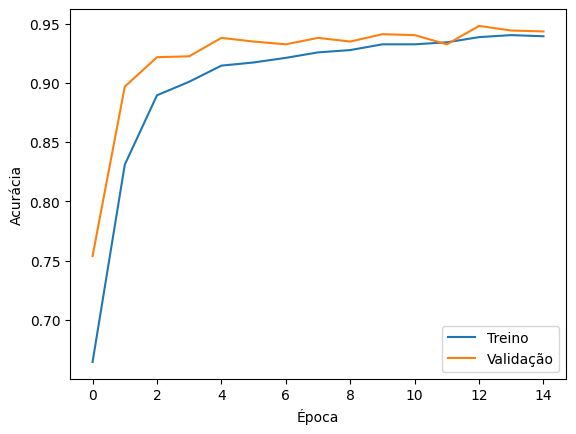

In [ ]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(train_accs, label='Treino')
plt.plot(val_accs, label='Validação')
plt.xlabel('Época')
plt.ylabel('Acurácia')
plt.legend()
plt.show()

A rede convolucional desenvolvida do zero apresentou comportamento de treinamento consistente, com aumento progressivo da acurácia de treinamento e validação. Não foram observados sinais relevantes de overfitting, uma vez que a acurácia de validação acompanhou de perto a acurácia de treinamento ao longo das épocas, indicando boa capacidade de generalização do modelo. Apesar de não ocorrer overfitting vamos utilizar uma técnica de regularização, no caso Dropout, para ver qual o efeito no gráfico das acurácias.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self, num_classes=3):
        super(SimpleCNN, self).__init__()

        # Bloco 1
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(2)
        self.dropout1 = nn.Dropout2d(0.2)

        # Bloco 2
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(2)
        self.dropout2 = nn.Dropout2d(0.2)

        # Bloco 3
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(2)
        self.dropout3 = nn.Dropout2d(0.2)

        # Camadas totalmente conectadas
        self.fc1 = nn.Linear(64 * 28 * 28, 64)
        self.dropout_fc = nn.Dropout(0.5)
        self.fc2 = nn.Linear(64, num_classes)

    def forward(self, x):
        x = self.pool1(self.dropout1(F.relu(self.conv1(x))))
        x = self.pool2(self.dropout2(F.relu(self.conv2(x))))
        x = self.pool3(self.dropout3(F.relu(self.conv3(x))))

        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.dropout_fc(x)
        x = self.fc2(x)

        return x

model_cnn_dropout = SimpleCNN()

E o otimizador:

In [ ]:
optimizer = torch.optim.Adam(model_cnn_dropout.parameters(), lr=2*1e-5)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") #importante para utilizarmos a gpu
model_cnn_dropout = model_cnn_dropout.to(device)
train_losses = []
val_losses = []
train_accs = []
val_accs = []

num_epochs = 15

for epoch in range(num_epochs):
    train_loss, train_acc = train_one_epoch(
        model_cnn_dropout, train_loader, optimizer, criterion, device
    )

    val_loss, val_acc = evaluate(
        model_cnn_dropout, val_loader, criterion, device
    )

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    train_accs.append(train_acc)
    val_accs.append(val_acc)

    print(
        f"Época {epoch+1}/{num_epochs} | "
        f"Train Loss: {train_loss:.4f} | "
        f"Train Acc: {train_acc:.4f} | "
        f"Val Loss: {val_loss:.4f} | "
        f"Val Acc: {val_acc:.4f}"
    )

Época 1/15 | Train Loss: 0.7752 | Train Acc: 0.6822 | Val Loss: 0.5937 | Val Acc: 0.7663
Época 2/15 | Train Loss: 0.5411 | Train Acc: 0.7724 | Val Loss: 0.3733 | Val Acc: 0.8540
Época 3/15 | Train Loss: 0.4354 | Train Acc: 0.8253 | Val Loss: 0.3022 | Val Acc: 0.8975
Época 4/15 | Train Loss: 0.3898 | Train Acc: 0.8525 | Val Loss: 0.2678 | Val Acc: 0.9138
Época 5/15 | Train Loss: 0.3583 | Train Acc: 0.8727 | Val Loss: 0.2374 | Val Acc: 0.9239
Época 6/15 | Train Loss: 0.3539 | Train Acc: 0.8703 | Val Loss: 0.2338 | Val Acc: 0.9208
Época 7/15 | Train Loss: 0.3290 | Train Acc: 0.8897 | Val Loss: 0.2128 | Val Acc: 0.9270
Época 8/15 | Train Loss: 0.3217 | Train Acc: 0.8868 | Val Loss: 0.2096 | Val Acc: 0.9301
Época 9/15 | Train Loss: 0.3143 | Train Acc: 0.8924 | Val Loss: 0.2106 | Val Acc: 0.9317
Época 10/15 | Train Loss: 0.3044 | Train Acc: 0.8953 | Val Loss: 0.2071 | Val Acc: 0.9309
Época 11/15 | Train Loss: 0.2913 | Train Acc: 0.9001 | Val Loss: 0.2053 | Val Acc: 0.9325
Época 12/15 | Train

Com isso, podemos gerar os gráficos:

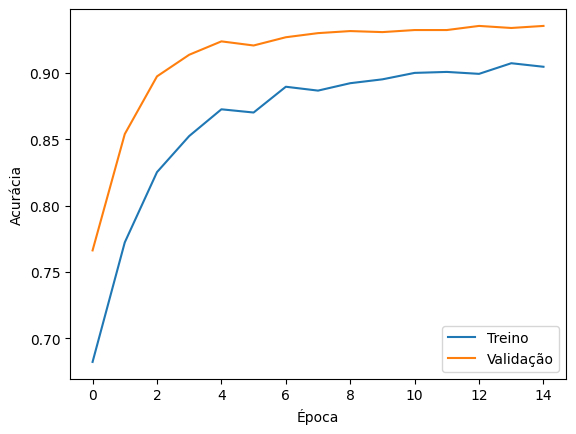

In [ ]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(train_accs, label='Treino')
plt.plot(val_accs, label='Validação')
plt.xlabel('Época')
plt.ylabel('Acurácia')
plt.legend()
plt.show()

Como consequência do uso do Dropout a acurácia de treinamento diminuiu e a estabilidade da validação continuou excelente. Essa diminuição na acurácia de treinamento possibilitaria que aumentássemos o learning rate que poderia levar a uma melhor acurácia tanto de treinamento como de validação.

# **Rede Pré-Treinada Congelada (ResNet18)**

Agora iremos utilizar uma rede pré-treinada. A rede escolhida foi a ResNet18 devido ao seu bom equilíbrio entre capacidade de generalização e custo computacional. Assim, temos:

In [ ]:
from torchvision import models
import torch.nn as nn

model_resnet_frozen = models.resnet18(
    weights=models.ResNet18_Weights.DEFAULT
)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 185MB/s]


Primeiramente queremos congelar toda sua parte convolucional

In [ ]:
for param in model_resnet_frozen.parameters():
    param.requires_grad = False

Por fim, substituímos o classificador final

In [ ]:
import torch

num_features = model_resnet_frozen.fc.in_features
model_resnet_frozen.fc = nn.Linear(num_features, 3)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_resnet_frozen = model_resnet_frozen.to(device)

Agora temos o otimizador e a função de loss

In [ ]:
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(
    model_resnet_frozen.fc.parameters(),
    lr=2*1e-3
)

In [ ]:
train_losses = []
val_losses = []
train_accs = []
val_accs = []

num_epochs = 15

for epoch in range(num_epochs):
    train_loss, train_acc = train_one_epoch(
        model_resnet_frozen, train_loader, optimizer, criterion, device
    )

    val_loss, val_acc = evaluate(
        model_resnet_frozen, val_loader, criterion, device
    )

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    train_accs.append(train_acc)
    val_accs.append(val_acc)

    print(
        f"Época {epoch+1}/{num_epochs} | "
        f"Train Loss: {train_loss:.4f} | "
        f"Train Acc: {train_acc:.4f} | "
        f"Val Loss: {val_loss:.4f} | "
        f"Val Acc: {val_acc:.4f}"
    )

Época 1/15 | Train Loss: 0.4497 | Train Acc: 0.8192 | Val Loss: 0.3345 | Val Acc: 0.8773
Época 2/15 | Train Loss: 0.2723 | Train Acc: 0.8992 | Val Loss: 0.2807 | Val Acc: 0.8812
Época 3/15 | Train Loss: 0.2445 | Train Acc: 0.9062 | Val Loss: 0.2008 | Val Acc: 0.9418
Época 4/15 | Train Loss: 0.2126 | Train Acc: 0.9237 | Val Loss: 0.2141 | Val Acc: 0.9293
Época 5/15 | Train Loss: 0.2171 | Train Acc: 0.9176 | Val Loss: 0.1852 | Val Acc: 0.9418
Época 6/15 | Train Loss: 0.2003 | Train Acc: 0.9274 | Val Loss: 0.1845 | Val Acc: 0.9394
Época 7/15 | Train Loss: 0.2020 | Train Acc: 0.9281 | Val Loss: 0.2345 | Val Acc: 0.9099
Época 8/15 | Train Loss: 0.1902 | Train Acc: 0.9300 | Val Loss: 0.1847 | Val Acc: 0.9363
Época 9/15 | Train Loss: 0.1889 | Train Acc: 0.9325 | Val Loss: 0.2092 | Val Acc: 0.9332
Época 10/15 | Train Loss: 0.1898 | Train Acc: 0.9320 | Val Loss: 0.1935 | Val Acc: 0.9317
Época 11/15 | Train Loss: 0.1905 | Train Acc: 0.9274 | Val Loss: 0.1996 | Val Acc: 0.9262
Época 12/15 | Train

Em seguida, podemos plotar os resultados:

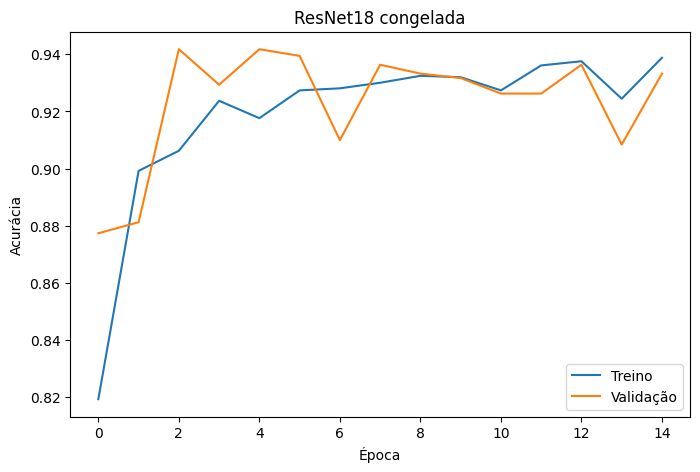

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(train_accs, label="Treino")
plt.plot(val_accs, label="Validação")
plt.xlabel("Época")
plt.ylabel("Acurácia")
plt.legend()
plt.title("ResNet18 congelada")
plt.show()

A ResNet18 pré-treinada com camadas convolucionais congeladas apresentou rápido ganho de desempenho nas primeiras épocas, além de curvas de treinamento e validação próximas e relativamente estáveis. Esse comportamento indica boa generalização e ausência de overfitting, evidenciando a eficácia do uso de redes pré-treinadas mesmo com um classificador simples.

#**Rede Pré-Treinada com Fine-Tuning (ResNet18)**

Por último, utilizaremos esse mesmo modelo pré-treinado mas agora com fine-tuning, ou seja, iremos também treinar as camadas convolucionais da rede.

In [ ]:
from torchvision import models
import torch.nn as nn

model_resnet_finetune = models.resnet18(
    weights=models.ResNet18_Weights.DEFAULT
)


E alteremos somente o classificador final da rede e permitindo que o restante possa ser treinado.

In [ ]:
num_features = model_resnet_finetune.fc.in_features
model_resnet_finetune.fc = nn.Linear(num_features, 3)

model_resnet_finetune = model_resnet_finetune.to(device)

Temos o loss e otimizador a seguir

In [ ]:
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(
    model_resnet_finetune.parameters(),
    lr = 1e-4
)

E finalmente o código de treino

In [ ]:
num_epochs = 15

train_accs, val_accs = [], []
train_losses, val_losses = [], []

for epoch in range(num_epochs):
    train_loss, train_acc = train_one_epoch(
        model_resnet_finetune, train_loader, optimizer, criterion, device
    )

    val_loss, val_acc = evaluate(
        model_resnet_finetune, val_loader, criterion, device
    )

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    print(
        f"Época {epoch+1}/{num_epochs} | "
        f"Train Loss: {train_loss:.4f} | "
        f"Train Acc: {train_acc:.4f} | "
        f"Val Loss: {val_loss:.4f} | "
        f"Val Acc: {val_acc:.4f}"
    )


Época 1/15 | Train Loss: 0.2069 | Train Acc: 0.9274 | Val Loss: 0.1673 | Val Acc: 0.9488
Época 2/15 | Train Loss: 0.0851 | Train Acc: 0.9701 | Val Loss: 0.0883 | Val Acc: 0.9643
Época 3/15 | Train Loss: 0.0841 | Train Acc: 0.9718 | Val Loss: 0.1613 | Val Acc: 0.9589
Época 4/15 | Train Loss: 0.0669 | Train Acc: 0.9759 | Val Loss: 0.0968 | Val Acc: 0.9666
Época 5/15 | Train Loss: 0.0526 | Train Acc: 0.9830 | Val Loss: 0.1270 | Val Acc: 0.9550
Época 6/15 | Train Loss: 0.0493 | Train Acc: 0.9825 | Val Loss: 0.1473 | Val Acc: 0.9596
Época 7/15 | Train Loss: 0.0369 | Train Acc: 0.9879 | Val Loss: 0.0791 | Val Acc: 0.9689
Época 8/15 | Train Loss: 0.0299 | Train Acc: 0.9881 | Val Loss: 0.0895 | Val Acc: 0.9658
Época 9/15 | Train Loss: 0.0338 | Train Acc: 0.9896 | Val Loss: 0.1017 | Val Acc: 0.9666
Época 10/15 | Train Loss: 0.0331 | Train Acc: 0.9886 | Val Loss: 0.1263 | Val Acc: 0.9643
Época 11/15 | Train Loss: 0.0242 | Train Acc: 0.9925 | Val Loss: 0.1123 | Val Acc: 0.9674
Época 12/15 | Train

Com esse resultado podemos plotar as curvas

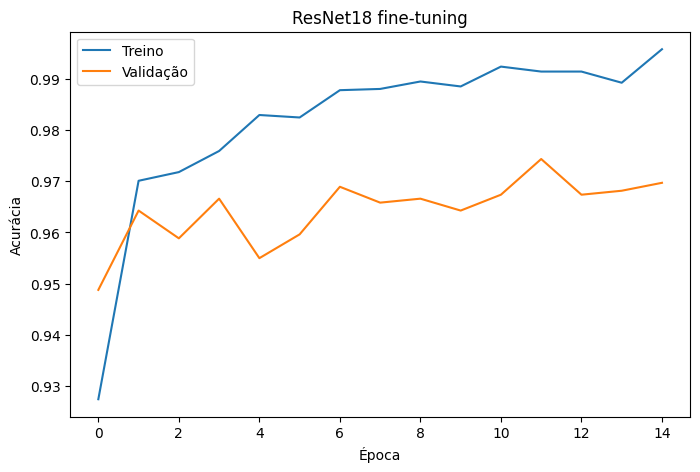

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(train_accs, label="Treino")
plt.plot(val_accs, label="Validação")
plt.xlabel("Época")
plt.ylabel("Acurácia")
plt.legend()
plt.title("ResNet18 fine-tuning")
plt.show()

Com isso, conseguimos verificar que a aplicação de fine-tuning na ResNet18 resultou no melhor desempenho geral entre os modelos avaliados, atingindo acurácia de validação acima de 95%. Apesar do aumento da diferença entre as curvas de treinamento e validação, não foram observados sinais significativos de overfitting, indicando que o ajuste fino das camadas convolucionais foi eficaz para capturar características específicas do domínio de imagens de raio-X.

# Análise final

Então, podemos usar o conjunto de teste e avaliar algumas métricas para sintetizarmos o desempenho de cada uma das redes treinadas.

Primeiro, implementa-se a função que irá testar os modelos:

In [ ]:
import torch
import numpy as np

def evaluate_model(model, dataloader, device):
    model.eval()

    y_true = []
    y_pred = []

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    return np.array(y_true), np.array(y_pred)


A partir do resultado do teste conseguimos obter as métricas desejadas com o código abaixo:

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, recall_score, f1_score

def compute_metrics(y_true, y_pred):
    metrics = {}

    metrics["accuracy"] = accuracy_score(y_true, y_pred)
    metrics["f1_macro"] = f1_score(y_true, y_pred, average="macro")

    recalls = recall_score(y_true, y_pred, average=None)

    metrics["recall_normal"] = recalls[1]
    metrics["recall_covid"] = recalls[0]
    metrics["recall_pneumonia"] = recalls[2]

    return metrics

E, por último, iremos criar uma tabela que exibe as métricas para cada um dos modelos:

In [ ]:
import pandas as pd

results = []

# CNN Simples
y_true, y_pred = evaluate_model(model_cnn, test_loader, device)
m = compute_metrics(y_true, y_pred)
results.append(["CNN Simples", *m.values()])

# CNN + Dropout
y_true, y_pred = evaluate_model(model_cnn_dropout, test_loader, device)
m = compute_metrics(y_true, y_pred)
results.append(["CNN + Dropout", *m.values()])

# ResNet18 Congelada
y_true, y_pred = evaluate_model(model_resnet_frozen, test_loader, device)
m = compute_metrics(y_true, y_pred)
results.append(["ResNet18 Congelada", *m.values()])

# ResNet18 Fine-tuning
y_true, y_pred = evaluate_model(model_resnet_finetune, test_loader, device)
m = compute_metrics(y_true, y_pred)
results.append(["ResNet18 Fine-tuning", *m.values()])

df = pd.DataFrame(
    results,
    columns=[
        "Modelo",
        "Acurácia",
        "F1 Macro",
        "Recall Normal",
        "Recall Covid",
        "Recall Pneumonia"
    ]
)

df

,Modelo,Acurácia,F1 Macro,Recall Normal,Recall Covid,Recall Pneumonia
0,CNN Simples,0.943323,0.933594,0.905363,0.913793,0.961404
1,CNN + Dropout,0.935559,0.919103,0.883281,0.870690,0.963743
2,ResNet18 Congelada,0.933230,0.920783,0.854890,0.862069,0.971930
3,ResNet18 Fine-tuning,0.969720,0.971809,0.933754,1.000000,0.978947


De maneira geral conseguimos observar que todos os modelos obtiveram ótimos resultados. O destaque evidente é para a ResNet18 com Fine-Tuning, a qual além de apresentar a maior acurácia geral apresentou Recall de 1.00 para o Covid, ou seja, o modelo conseguiu detectar todas as pessoas que foram examinadas e tinham realmente Covid. Para que essa rede tivesse utilidade médica teríamos que tornar o recall da pneumonia também 1.00 por meio da alteração do limiar de decisão, aumentando o número de épocas do treinamento e/ou enriquecendo mais o dataset de treinamento, o que permitiria garantir que caso um exame fosse classificado como normal que ele realmente estaria indicando uma pessoa saudável (pelo menos em relação a essas duas doenças).


O F1-Score macro permite observarmos se há um equilíbrio entre recall e precisão nas classes em geral e se o modelo está realmente conseguindo distinguí-las. A CNN Simples e a ResNet18 foram os destaques nesse quesito, apesar dos outros modelos também obterem um bom desempenho. Na CNN+Dropout, o Dropout acaba tornando o modelo mais conservador e isso provavelmente impactou na capacidade do modelo aprender padrões. Já na ResNet18 Congelada é possível concluir, principalmente observando o resultado obtido com Fine-Tuning, que apesar de já estar pré-treinada o treinamento somente do classificador final não foi suficiente para aprender totalmente os padrões e distinguir as classes.

Além disso, é importante citar que o desbalanceamento no dataset (que apresenta maior número de imagens que representam pneumonia) é evidenciado quando observamos o recall das classes. Exceto no modelo ResNet18 com Fine-Tuning, os modelos apresentaram recall maior para pneumonia do que para as outras classes, isso indica que por serem treinados por uma quantidade maior de imagens dessa classe os modelos conseguiram aprender mais padrões e, consequentemente, conseguem identificar mais casos.

Por fim, é de grande importância citar que apesar de se ter uma quantidade menor de imagens para Covid que o modelo ResNet18 com Fine-Tuning conseguiu identificar a totalidade deles. Isso mostra o potencial do Fine-Tuning: consegue aprender detalhes sutis que permitiram diferenciar o Covid das outras classes, apesar de termos uma quantidade de imagens menor dessa classe do que das outras.